In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as sps

from utils_dopt import *
from utils_plot import *
from utils import *

%load_ext autoreload
%autoreload 2

# Test one shot sampling techniques

In [41]:
def lin_opt(X, Xt, f, N, n0, step):
    fpreds = {}
    runtimes = []

    for k in tqdm(range(n0, N+step, step), disable=False):
        time_start = timeit.default_timer()
        if Xt is None:
            xk_idxs = np.random.randint(0, len(X), k)
        else:
            V, l, stats = doptimal(Xt, int(k*2))
            xk_idxs = get_indices(Xt, V, l, k)

        Xk = X[xk_idxs]
        fk = f[xk_idxs]
        fpred = sm.OLS(fk, sm.add_constant(Xk), hasconst=True).fit().predict(sm.add_constant(X))
        runtimes += [timeit.default_timer() - time_start]
        fpreds[k] = fpred
        
    return fpreds, runtimes

In [24]:
def bootstrap_lin_stats(X, Xt, f, N, n0, n_bootstrap, results_true, step=5):
    stats = [k for k in results_true.keys() if not k.startswith('test_')]
    bootstrap_results = dict_list()

    for i in tqdm(range(n_bootstrap)):
        fpreds, runtimes = lin_opt(X, Xt, f, N, n0, step)
        results = get_stats(fscale, fpreds)
        results['runtime'] = runtimes
        
        for stat in stats:
            diff = np.array(np.abs(results[stat] - results_true[stat][0]))
            bootstrap_results.add(stat, diff)

    
    for stat in stats:
        bootstrap_results[stat] = np.array(bootstrap_results[stat])
    
    return bootstrap_results, results, fpreds

## Read in data

## Load data

In [25]:
data_in = np.load('../data/pca_encoding.npy')
# columns=['index', sample_num', 'operating_cost', 'market_rev', 'runtime'
data_out_base = pd.read_csv('../data/combined_basecase.csv', header=None)
data_out_hvdc = pd.read_csv('../data/combined_hvdc.csv', header=None)

D = 10
X = data_in[:,:D]
n, d = X.shape

f = data_out_hvdc.to_numpy()[:,2] - data_out_base.to_numpy()[:,2]
time_model = data_out_base.to_numpy()[:,4].mean()

In [26]:
fscale = StandardScaler().fit_transform(f.reshape(-1,1)).flatten()
Xscale = StandardScaler().fit_transform(X)

In [27]:
n0, N = 5, 50
n_bootstrap = 100
l = 2
save_mode = True

## Train surrogate model

In [28]:
results_true = dict_list()
results_true = add_stats(results_true, fscale, fscale)
results_true['runtime'] = [time_model*n]

In [87]:
# scale and discretize
strategies = ['uniform', 'quantile', 'kmeans']
Xt, __, __ = scale_and_discretize(X, strategies[1], 10)

# Get D-optimal performance

In [88]:
V, l, stats = doptimal(Xt, int(N*2))
xk_idxs = get_indices(Xt, V, l, N)
Xk = Xscale[xk_idxs]
fk = fscale[xk_idxs]
fpred_dopt = sm.OLS(fk, sm.add_constant(Xk), hasconst=True).fit().predict(sm.add_constant(Xscale))

In [89]:
results_dopt = get_stats(fscale, {50:fpred_dopt})

In [99]:
stats = [k for k in results_true.keys() if not k.startswith(('test_', 'run'))]
diff_results = dict_list()

for stat in stats:
    diff = np.abs(results_dopt[stat][0] - results_true[stat][0])
    diff_results.add(stat, diff)


In [50]:
fpreds_dopt, runtimes_dopt = lin_opt(Xscale, Xt, fscale, 50, 48, step)
results_dopt = get_stats(fscale, fpreds_dopt)
results_dopt['runtime'] = runtimes_dopt

100%|█████████████████████████████████████████████| 3/3 [00:50<00:00, 16.95s/it]


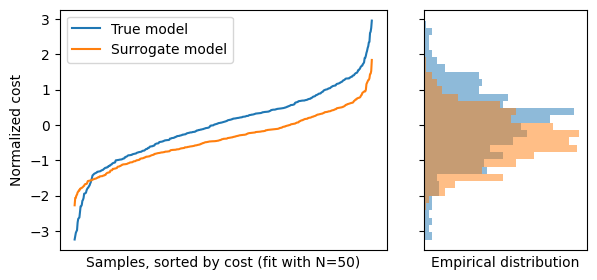

In [86]:
pre = 'dopt'
results, fpreds = results_dopt, fpreds_dopt

file_names = [None, None, None]
if save_mode:
    file_names = [pre+'_dist', pre+'_boxplot', pre+'_statsboot']
plot_dist(fscale, fpred_dopt, N=N, bins=30, save_file=file_names[0])
# plot_boxplots(fscale, fpreds, xlim=(-5, 5), save_file=file_names[1])
# plot_stats(results_true, results, save_file=file_names[2])

# Get the random-sample baseline

In [30]:
bootstrap_rand, results_rand, fpreds_rand = bootstrap_lin_stats(
    Xscale, None, fscale, N, n0, n_bootstrap, results_true, step)

100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.42it/s]


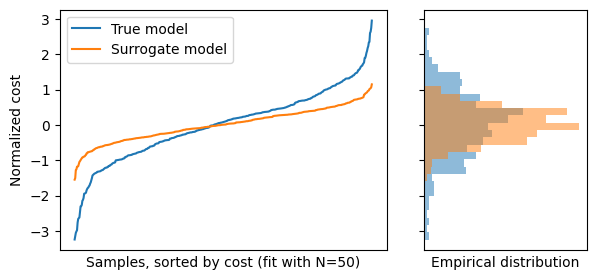

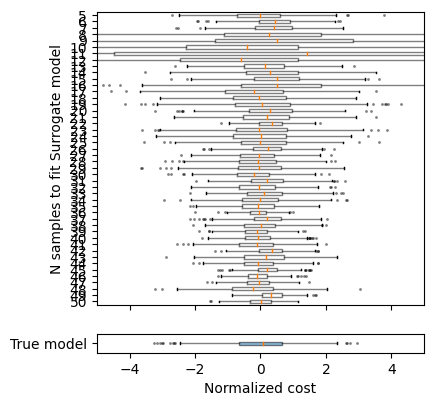

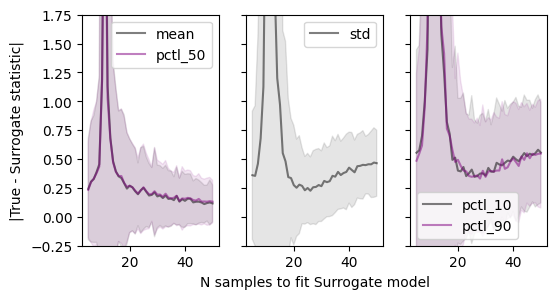

In [31]:
pre = 'rand_lin'
results, fpreds = results_rand, fpreds_rand

file_names = [None, None, None]
if save_mode:
    file_names = [pre+'_dist', pre+'_boxplot', pre+'_statsboot']
plot_dist(fscale, fpreds[N], N = N, bins=30, save_file=file_names[0])
plot_boxplots(fscale, fpreds, xlim=(-5, 5), save_file=file_names[1])
plot_stats_boot(bootstrap_rand, n0, N, step=step, save_file=file_names[2])

# Summarize